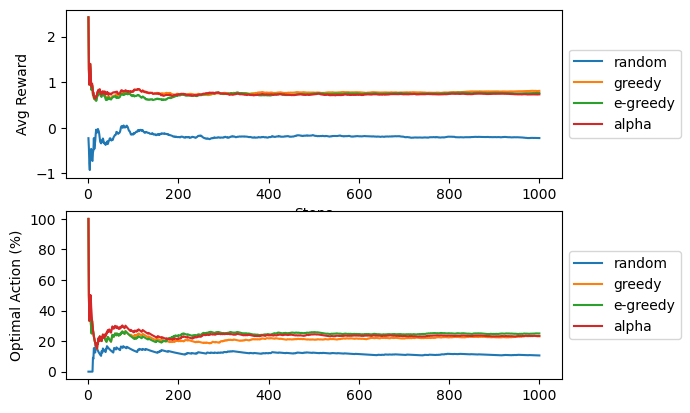

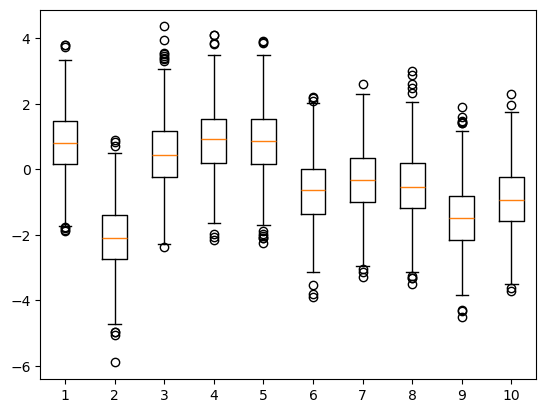

In [63]:
import random
import numpy as np
import matplotlib.pyplot as plt

k = 10

def default_bandit(a: int) -> float:
    if a == 1:
        return 1.0
    else:
        return 0.0

def distributed_bandit(deviation=1) -> float:
    distributed_avgs = [np.random.normal(0, deviation) for _ in range(k)]

    def bandit(action: int, dev_per_action=1) -> float:
        return distributed_avgs[action-1] + np.random.normal(0, dev_per_action)

    return bandit

def default_epsilon(step: int) -> float:
    return 0.1

def default_alpha(step: int, n: int) -> float:
    return 1/n

def plot(results: list[tuple[str, list[tuple[int, float, float]]]]) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1)

    for name, result in results:
        steps, avg_r, opt_a = zip(*result)
        ax1.plot(steps, avg_r, '-', label=name)
        ax2.plot(steps, opt_a, '-', label=name)

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Avg Reward')
    ax2.set_ylabel('Optimal Action (%)')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

class Params:
    def __init__(
        self,
        name='default',
        initial_q=0.0,
        get_epsilon=default_epsilon,
        get_alpha=default_alpha,
    ):
        self.name = name
        self.initial_q = initial_q
        self.get_epsilon = get_epsilon
        self.get_alpha = get_alpha

def run(all_rewards: list[list[float]], params: Params):
    name = params.name
    initial_q = params.initial_q
    get_epsilon = params.get_epsilon
    get_alpha = params.get_alpha

    q = [initial_q] * k
    n = [0] * k
    r_total = 0
    opt_total = 0

    result: list[tuple[str, int, float, float]] = []

    for i, rewards in enumerate(all_rewards):
        step = i + 1
        epsilon = get_epsilon(step)

        if random.random() < epsilon:
            a: int = random.randint(1, k)
        else:
            a: int = np.argmax(q) + 1

        r = rewards[a-1]
        n[a-1] += 1
        alpha = get_alpha(step, n[a-1])
        q[a-1] += alpha * (r - q[a-1])

        r_total += r
        r_avg = r_total / step
        best_r = max(rewards)
        is_best_a = r == best_r
        opt_total += 1 if is_best_a else 0
        opt_percent = 100.0 * opt_total / step
        result.append((step, r_avg, opt_percent))

    return name, result

def main(steps=1000, bandit=default_bandit, plot_rewards=False, cases: list[Params] = []):
    cases = cases or [Params()]
    all_rewards = [[bandit(i) for i in range(1, k+1)] for step in range(1, steps+1)]
    results = [run(all_rewards, case) for case in cases]
    plot(results)

    if plot_rewards:
        r_per_a = list(zip(*all_rewards))
        plt.boxplot(r_per_a)
        plt.show()

main(bandit=distributed_bandit(1), plot_rewards=True, cases=[
    Params(name='random', get_epsilon=lambda step: 1),
    Params(name='greedy', get_epsilon=lambda step: 0),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

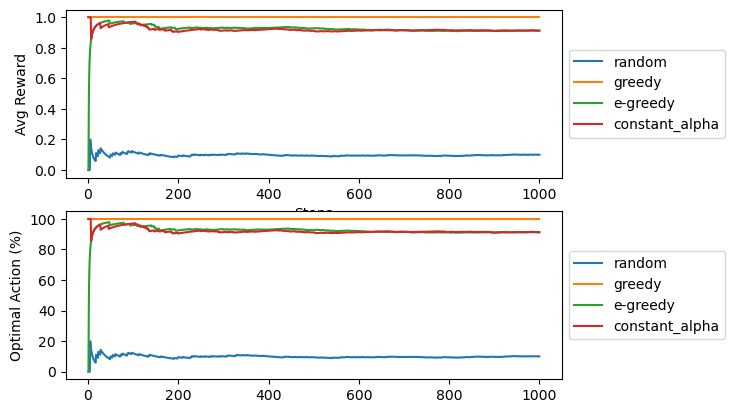

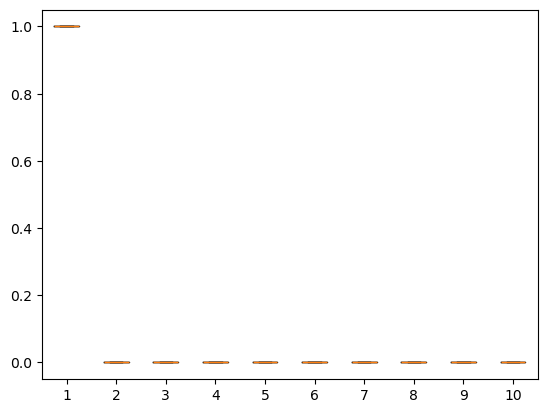

In [83]:
main(bandit=default_bandit, plot_rewards=True, cases=[
    Params(name='random', get_epsilon=lambda step: 1),
    Params(name='greedy', get_epsilon=lambda step: 0),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

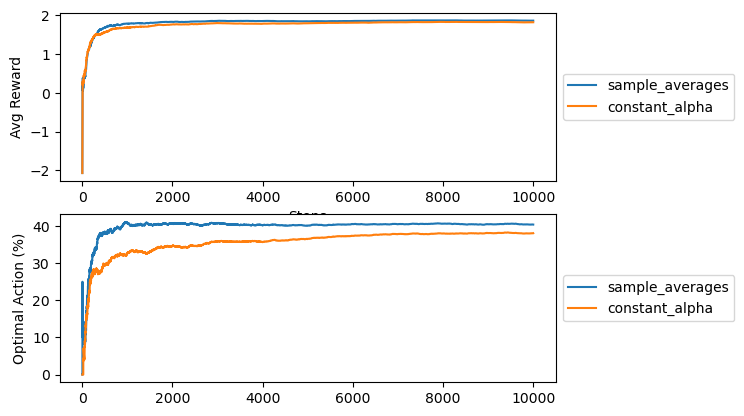

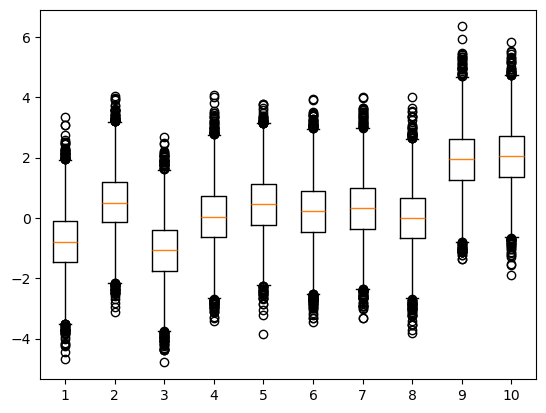

In [77]:
# Exercise 2.5 (pg. 55)

main(steps=10000, bandit=distributed_bandit(1), plot_rewards=True, cases=[
    Params(name='sample_averages', get_epsilon=lambda _: 0.1),
    Params(name='constant_alpha', get_epsilon=lambda step: 0.1, get_alpha=lambda step, n: 0.1),
])

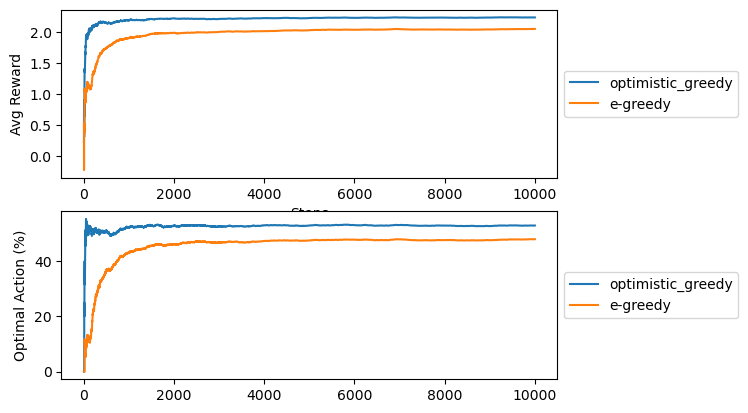

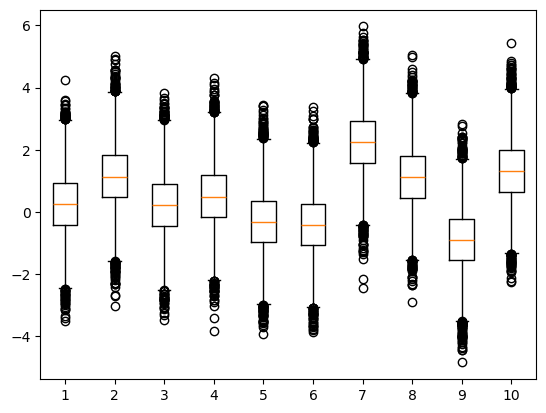

In [82]:
# initial_q=5
main(steps=10000, bandit=distributed_bandit(1), plot_rewards=True, cases=[
    Params(name='optimistic_greedy', get_epsilon=lambda _: 0, initial_q=5),
    Params(name='e-greedy', get_epsilon=lambda step: 0.1),
])